# **FC-DNN**

In [287]:
import numpy as np
import mne
import pandas as pd
import mne_bids
import matplotlib.pyplot as plt
import WaveGlow_functions
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
import torch
import datetime
import gc
import os
import pickle
import sys
import argparse
from datetime import datetime, timedelta
from subprocess import call, check_output, run
import matplotlib.pyplot as plt
import mne
import numpy as np
import scipy
import librosa
import scipy.signal
import scipy.stats
import scipy.io.wavfile
import scipy.fftpack
import scipy.io as sio
import skimage.transform
import soundfile as sf
import tensorflow as tf
import scipy
import scipy.io
# import scipy.io.wavfile
import scipy.io.wavfile as io_wav

In [288]:
# do not use all GPU memory
from tensorflow.compat.v1.keras.backend import set_session
import tensorflow.compat.v1 as tf
config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.3
config.gpu_options.allow_growth = True 
sess = tf.Session(config=config)
set_session(sess)

2023-05-17 16:59:32.730579: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-17 16:59:32.730980: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-17 16:59:32.731445: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-17 16:59:32.732027: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-17 16:59:32.732059: I tensorflow/core/co

### **Helper functions**

In [289]:
#Small helper function to speed up the hilbert transform by extending the length of data to the next power of 2
hilbert3 = lambda x: scipy.signal.hilbert(x, scipy.fftpack.next_fast_len(len(x)),axis=0)[:len(x)]

In [290]:
def extractHG(data, sr, windowLength=0.05, frameshift=0.01, bandpass_min=70, bandpass_max=170):
    """
    Window data and extract frequency-band envelope using the hilbert transform
    
    Parameters
    ----------
    data: array (samples, channels)
        EEG time series
    sr: int
        Sampling rate of the data
    windowLength: float
        Length of window (in seconds) in which spectrogram will be calculated
    frameshift: float
        Shift (in seconds) after which next window will be extracted
    Returns
    ----------
    feat: array (windows, channels)
        Frequency-band feature matrix
    """
    #Linear detrend
    data = scipy.signal.detrend(data,axis=0)
    #Number of windows
    numWindows = int(np.floor((data.shape[0]-windowLength*sr)/(frameshift*sr)))
    #Filter High-Gamma Band
    # sos = scipy.signal.iirfilter(4, [70/(sr/2),170/(sr/2)],btype='bandpass',output='sos')
    sos = scipy.signal.iirfilter(4, [bandpass_min/(sr/2),bandpass_max/(sr/2)],btype='bandpass',output='sos')
    data = scipy.signal.sosfiltfilt(sos,data,axis=0)
    #Attenuate first harmonic of line noise
    # sos = scipy.signal.iirfilter(4, [98/(sr/2),102/(sr/2)],btype='bandstop',output='sos')
    # data = scipy.signal.sosfiltfilt(sos,data,axis=0)
    #Attenuate second harmonic of line noise
    # sos = scipy.signal.iirfilter(4, [148/(sr/2),152/(sr/2)],btype='bandstop',output='sos')
    # data = scipy.signal.sosfiltfilt(sos,data,axis=0)
    #Create feature space
    data = np.abs(hilbert3(data))
    feat = np.zeros((numWindows,data.shape[1]))
    for win in range(numWindows):
        start= int(np.floor((win*frameshift)*sr))
        stop = int(np.floor(start+windowLength*sr))
        feat[win,:] = np.mean(data[start:stop,:],axis=0)
    return feat

In [291]:
def stackFeatures(features, modelOrder=4, stepSize=5):
    """
    Add temporal context to each window by stacking neighboring feature vectors
    
    Parameters
    ----------
    features: array (windows, channels)
        Feature time series
    modelOrder: int
        Number of temporal context to include prior to and after current window
    stepSize: float
        Number of temporal context to skip for each next context (to compensate for frameshift)
    Returns
    ----------
    featStacked: array (windows, feat*(2*modelOrder+1))
        Stacked feature matrix
    """
    featStacked=np.zeros((features.shape[0]-(2*modelOrder*stepSize),(2*modelOrder+1)*features.shape[1]))
    for fNum,i in enumerate(range(modelOrder*stepSize,features.shape[0]-modelOrder*stepSize)):
        ef=features[i-modelOrder*stepSize:i+modelOrder*stepSize+1:stepSize,:]
        featStacked[fNum,:]=ef.flatten() #Add 'F' if stacked the same as matlab
    return featStacked

In [292]:
# WaveGlow / Tacotron2 / STFT parameters for audio data
# samplingFrequency = 16000
samplingFrequency = 22050
#samplingFrequency_EEG = 512 #sub 07
winL_EEG = 0.05
# frameshift_EEG = 0.01 # 10 ms
frameshift_EEG = 0.01 # 10 ms
frameshift_speech = 220 # 10ms
# modelOrder_EEG = 1
# modelOrder_EEG = 2
modelOrder_EEG = 4
# modelOrder_EEG = 10
stepSize_EEG = 5

In [293]:
stft = WaveGlow_functions.TacotronSTFT(
        filter_length=1024,
        hop_length=frameshift_speech,
        win_length=1024,
        n_mel_channels=80,
        sampling_rate=samplingFrequency,
        mel_fmin=0,
        mel_fmax=8000)

### **Load Data**

In [294]:
from pydub import AudioSegment

# Load Audio
wavfile = 'data/stimuli/6min.wav'
audio = AudioSegment.from_file(wavfile, format='wav')

# Shift audio by 150 ms
shifted_audio = audio._spawn(audio.raw_data, overrides={'frame_rate': audio.frame_rate, 'frame_width': audio.sample_width})
shifted_audio = shifted_audio._spawn(shifted_audio.raw_data, overrides={'frame_rate': shifted_audio.frame_rate + int(22050*0.15)})
shifted_audio = shifted_audio.set_frame_rate(audio.frame_rate)
shifted_audio = shifted_audio.set_channels(audio.channels)

# Export shifted audio as WAV file
shifted_audio.export('shifted_audio.wav', format='wav')

#Load Audio
wavfile = 'shifted_audio.wav'
mel_data = WaveGlow_functions.get_mel(wavfile, stft)
mel_data = np.fliplr(np.rot90(mel_data.data.numpy(), axes=(1, 0)))


# Print out the duration of the original and shifted audio
print("Original audio duration:", audio.duration_seconds)
print("Shifted audio duration:", shifted_audio.duration_seconds)

Original audio duration: 390.5706666666667
Shifted audio duration: 365.396375


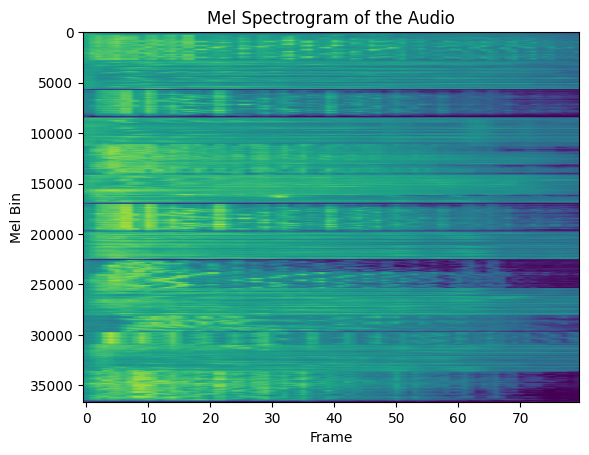

In [295]:
plt.imshow(mel_data, aspect='auto')
plt.xlabel('Frame')
plt.ylabel('Mel Bin')
plt.title('Mel Spectrogram of the Audio')
plt.show()

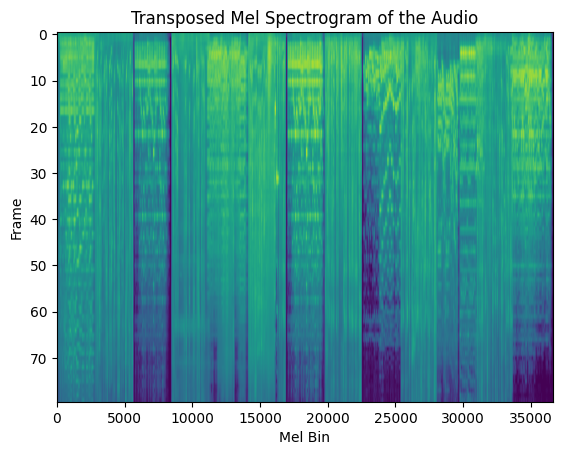

In [296]:
plt.imshow(np.transpose(mel_data), aspect='auto')
plt.xlabel('Mel Bin')
plt.ylabel('Frame')
plt.title('Transposed Mel Spectrogram of the Audio')
plt.show()


In [297]:
#Load Subjects
bids_dir = 'data'
subjects = mne_bids.get_entity_vals(bids_dir, 'subject')
#Choose subjects
subject = '46'
acquisition = 'clinical'
task = 'film'
datatype = 'ieeg'
session = 'iemu'


In [298]:
#load subject's channels
channels_path = mne_bids.BIDSPath(subject=subject,
                                    session=session,
                                    suffix='channels',
                                    extension='tsv',
                                    datatype=datatype,
                                    task=task,
                                    acquisition=acquisition,
                                    root=bids_dir)

/tmp/ipykernel_18769/705515975.py:2: FutureWarning: extension should start with a period ".", but got: "tsv". Prepending "." to form: ".tsv". This will raise an exception starting with MNE-BIDS 0.12.
  channels_path = mne_bids.BIDSPath(subject=subject,


In [299]:
channels = pd.read_csv(str(channels_path.match()[0]), sep='\t', header=0, index_col=None)
#print(channels)

In [300]:
#set channel types
data_path = mne_bids.BIDSPath(subject=subject,
                                    session=session,
                                    suffix='ieeg',
                                    extension='vhdr',
                                    datatype=datatype,
                                    task=task,
                                    acquisition=acquisition,
                                    root=bids_dir)
raw = mne.io.read_raw_brainvision(str(data_path.match()[0]), scale=1.0, preload=False, verbose=True)
raw.set_channel_types({ch_name: str(x).lower()
                if str(x).lower() in ['ecog', 'seeg', 'eeg'] else 'misc'
                                for ch_name, x in zip(raw.ch_names, channels['type'].values)})
raw.drop_channels([raw.ch_names[i] for i, j in enumerate(raw.get_channel_types()) if j == 'misc'])

/tmp/ipykernel_18769/3732428725.py:2: FutureWarning: extension should start with a period ".", but got: "vhdr". Prepending "." to form: ".vhdr". This will raise an exception starting with MNE-BIDS 0.12.
  data_path = mne_bids.BIDSPath(subject=subject,


Extracting parameters from data/sub-46/ses-iemu/ieeg/sub-46_ses-iemu_task-film_acq-clinical_run-1_ieeg.vhdr...
Setting channel info structure...


/tmp/ipykernel_18769/3732428725.py:11: RuntimeWarning: The unit for channel(s) AH+, ECG+, MKR1+, MKR2+, abdo+, emg+, emg2+, emg3+, orb+, thor+ has changed from V to NA.
  raw.set_channel_types({ch_name: str(x).lower()


<RawBrainVision | sub-46_ses-iemu_task-film_acq-clinical_run-1_ieeg.eeg, 64 x 207134 (404.6 s), ~68 kB, data not loaded>

print(raw)

### Discard Bad Channels

In [301]:
#bad channels
bad_channels = channels['name'][(channels['type'].isin(['ECOG', 'SEEG'])) & (channels['status'] == 'bad')].tolist()
raw.info['bads'].extend([ch for ch in bad_channels])
raw.drop_channels(raw.info['bads'])

<RawBrainVision | sub-46_ses-iemu_task-film_acq-clinical_run-1_ieeg.eeg, 59 x 207134 (404.6 s), ~63 kB, data not loaded>

### Load Raw Data

In [302]:
raw.load_data()

Reading 0 ... 207133  =      0.000 ...   404.557 secs...


<RawBrainVision | sub-46_ses-iemu_task-film_acq-clinical_run-1_ieeg.eeg, 59 x 207134 (404.6 s), ~93.3 MB, data loaded>

In [303]:
n_eeg_channels = int(raw.info['nchan']) # for subject 01
print('n_eeg_channels', n_eeg_channels)
# raise

n_eeg_channels 59


### Apply notch filter to remove line noise

In [304]:
raw.notch_filter(freqs=np.arange(50, 251, 50))

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  59 out of  59 | elapsed:    0.3s finished


<RawBrainVision | sub-46_ses-iemu_task-film_acq-clinical_run-1_ieeg.eeg, 59 x 207134 (404.6 s), ~93.3 MB, data loaded>

raw.plot()
plt.show()

### Apply common average reference to remove common noise and trends

In [305]:
#CAR
raw_car, _ = mne.set_eeg_reference(raw.copy(), 'average')

ECoG channel type selected for re-referencing
Applying average reference.
Applying a custom ('ECoG',) reference.


In [306]:
gamma = raw_car.copy().filter(60, 120).apply_hilbert(envelope=True).get_data()#.T
print('raw_car.shape:', raw_car._data.shape, 'gamma shape: ', gamma.shape)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 60 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 60.00
- Lower transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 52.50 Hz)
- Upper passband edge: 120.00 Hz
- Upper transition bandwidth: 30.00 Hz (-6 dB cutoff frequency: 135.00 Hz)
- Filter length: 113 samples (0.221 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  59 out of  59 | elapsed:    0.5s finished


raw_car.shape: (59, 207134) gamma shape:  (59, 207134)


#Extract signal in gamma range, use Hilbert transform, but can also play around with wavelet decomposition options


gamma = raw_car.copy().filter(60, 120).apply_hilbert(envelope=True).get_data().T

### Read annotation with event markers

In [307]:
custom_mapping = {'Stimulus/music': 2, 'Stimulus/speech': 1,
                  'Stimulus/end task': 5}  # 'Stimulus/task end' in laan
events, event_id = mne.events_from_annotations(raw_car, event_id=custom_mapping,
                                                         use_rounding=False)

Used Annotations descriptions: ['Stimulus/end task', 'Stimulus/music', 'Stimulus/speech']


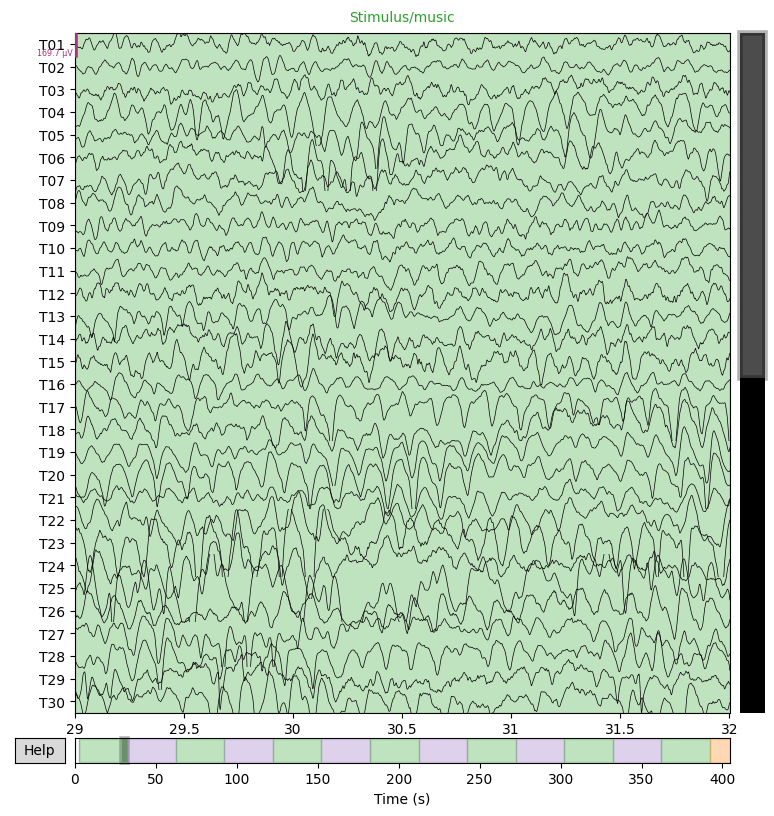

In [308]:
#plotting
raw_car.plot(n_channels=30,scalings='auto', duration=3, start=29)
plt.show()

In [309]:
# assume gamma is a 2D array
np.savetxt("gamma.tsv", gamma, delimiter="\t")

raise

In [310]:
#get EEG SR
n_melspec = 80
samplingFrequency_EEG=raw_car.info['sfreq']

### Crop to keep only the segments while wathcing the stimuli ( 6.5 min long movie)

In [311]:
#create a copy taht we crop
raw_car_cut = raw_car._data.copy()
print(raw_car_cut.shape)

(59, 207134)


In [312]:
print('before cut: ', raw_car._data.shape, mel_data.shape)

raw_car_cut = np.empty((n_eeg_channels,0))
mel_data_cut = np.empty((0,n_melspec))


# for i in range(6):
for i in range(6):
    start_time = events[2*i+1, 0] / raw_car.info['sfreq']
    end_time = events[2*i+2, 0] / raw_car.info['sfreq']
    start_idx, end_idx = raw_car.time_as_index([start_time, end_time])
    print(i, 'iEEG index', start_idx, end_idx, end_idx-start_idx)
    n_frames_per_sec = int(1 / frameshift_EEG)
    print(i, 'melspec index', (2*i+1)*30*n_frames_per_sec, (2*i+2)*30*n_frames_per_sec, (2*i+2)*30*n_frames_per_sec-(2*i+1)*30*n_frames_per_sec)
    # raw_car_cut1 = raw_car._data[:, start_idx:end_idx]
    raw_car_cut1 = gamma[:, start_idx:end_idx]
    raw_car_cut = np.append(raw_car_cut, raw_car_cut1, axis=1)
    mel_data_cut1 = mel_data[(2*i+1)*30*n_frames_per_sec : (2*i+2)*30*n_frames_per_sec]
    mel_data_cut = np.append(mel_data_cut, mel_data_cut1, axis=0)
# raise
mel_data = mel_data_cut

print('after cut: ', raw_car_cut.shape, mel_data.shape)
# raise
#praat

before cut:  (59, 207134) (36623, 80)
0 iEEG index 16511 31871 15360
0 melspec index 3000 6000 3000
1 iEEG index 47231 62591 15360
1 melspec index 9000 12000 3000
2 iEEG index 77982 93311 15329
2 melspec index 15000 18000 3000
3 iEEG index 108671 124031 15360
3 melspec index 21000 24000 3000
4 iEEG index 139391 154751 15360
4 melspec index 27000 30000 3000
5 iEEG index 170111 185471 15360
5 melspec index 33000 36000 3000
after cut:  (59, 92129) (18000, 80)


In [313]:
#get EEG SR
samplingFrequency_EEG=raw_car.info['sfreq']

# Calculate the length of the signal
length = raw_car_cut.shape[1] / samplingFrequency_EEG 

print("The length of the EEG signal is", length,"s")
print(samplingFrequency_EEG)


The length of the EEG signal is 179.939453125 s
512.0


### Prepare Data for training

### Extract features

In [314]:
#Extract HG features
print('calculating Hilbert...', raw_car_cut.shape)
# eeg_fft = np.empty((n_max_frames, n_freq_bands, n_eeg_channels * (2 * modelOrder_EEG + 1) ))
# feat_Hilbert_1 = extractHG(raw_car_cut,samplingFrequency_EEG, windowLength=winL_EEG,frameshift=frameshift_EEG, bandpass_min=1, bandpass_max=200)
feat_Hilbert_1 = extractHG(np.rot90(raw_car_cut),samplingFrequency_EEG, windowLength=winL_EEG,frameshift=frameshift_EEG, bandpass_min=1, bandpass_max=200)
# feat_Hilbert_2 = extractHG(np.rot90(current_raw_eeg_data),samplingFrequency_EEG, windowLength=winL_EEG,frameshift=frameshift_EEG, bandpass_min=51, bandpass_max=100)
# feat_Hilbert_3 = extractHG(np.rot90(current_raw_eeg_data),samplingFrequency_EEG, windowLength=winL_EEG,frameshift=frameshift_EEG, bandpass_min=101, bandpass_max=150)
# feat_Hilbert_4 = extractHG(np.rot90(current_raw_eeg_data),samplingFrequency_EEG, windowLength=winL_EEG,frameshift=frameshift_EEG, bandpass_min=151, bandpass_max=200)

calculating Hilbert... (59, 92129)


In [315]:
#Stack features
feat_Hilbert_1 = stackFeatures(feat_Hilbert_1,modelOrder=modelOrder_EEG,stepSize=stepSize_EEG)

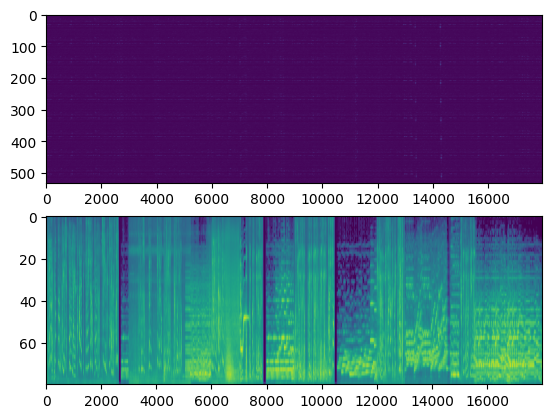

In [316]:

plt.subplot(211)
plt.imshow(np.rot90(feat_Hilbert_1), aspect='auto')

plt.subplot(212)
plt.imshow(np.rot90(mel_data), aspect='auto')
plt.show()


eeg = feat_Hilbert_1

In [317]:
min_len = np.min((len(eeg), len(mel_data)))
eeg = eeg[0:min_len]
mel_data = mel_data[0:min_len]

In [318]:
print('mel & iEEG: ', mel_data.shape, feat_Hilbert_1.shape)

mel & iEEG:  (17948, 80) (17948, 531)


In [319]:
train_index = np.arange(0, int(0.8 * eeg.shape[0]))
test_index = np.arange(int(0.8 * eeg.shape[0]), eeg.shape[0])

In [320]:
# train-validation-test split
eeg_train = eeg[0 : int(len(eeg) * 0.8)]
eeg_valid = eeg[int(len(eeg) * 0.8) : int(len(eeg) * 0.9)]
eeg_test =  eeg[int(len(eeg) * 0.9) : ]    

In [321]:
melspec_train = mel_data[0 : int(len(mel_data) * 0.8)]
melspec_valid = mel_data[int(len(mel_data) * 0.8) : int(len(mel_data) * 0.9)]
melspec_test =  mel_data[int(len(mel_data) * 0.9) : ]    

In [322]:
# scale input to [0-1]
eeg_scaler = MinMaxScaler()
# eeg_scaler = StandardScaler(with_mean=True, with_std=True)
eeg_train_scaled = eeg_scaler.fit_transform(eeg_train)
eeg_valid_scaled = eeg_scaler.transform(eeg_valid)
eeg_test_scaled  = eeg_scaler.transform(eeg_test)

In [323]:
# scale outpit mel-spectrogram data to zero mean, unit variances
melspec_scaler = StandardScaler(with_mean=True, with_std=True)
melspec_train_scaled = melspec_scaler.fit_transform(melspec_train)
melspec_valid_scaled = melspec_scaler.transform(melspec_valid)
melspec_test_scaled  = melspec_scaler.transform(melspec_test)

### FC-DNN

In [342]:
# 5 hidden layers, with 1000 neuron on each layer
model = Sequential()
model.add(
    Dense(
       8000,
        input_dim=eeg_train_scaled.shape[1],
        kernel_initializer='normal',
        activation='relu'))

model.add(
    Dense(
       4000,
        input_dim=eeg_train_scaled.shape[1],
        kernel_initializer='normal',
        activation='relu'))
model.add(
    Dense(
        80,
        kernel_initializer='normal',
        activation='linear'))

In [343]:
# compile model
model.compile(
    loss='mean_squared_error',
    metrics=['mean_squared_error'],
    optimizer='adam')
earlystopper = EarlyStopping(
    monitor='val_mean_squared_error',
    min_delta=0.001,
    patience=5,
    verbose=1,
    mode='auto')

if not (os.path.isdir('models_iEEG_to_melspec/')):
    os.mkdir('models_iEEG_to_melspec/')

In [344]:
# early stopping to avoid over-training
# csv logger
current_date = '{date:%Y-%m-%d_%H-%M-%S}'.format(
    date=datetime.now())
print(current_date)
# n_eeg_channels * (2 * modelOrder_EEG + 1)
model_name = 'models_iEEG_to_melspec/iEEG-Hilbert_to_melspec_DNN_modelOrder-' + str(modelOrder_EEG).zfill(2) + '_freqBands-1_' + '_sub' + subject + '_' + current_date
logger = CSVLogger(model_name + '.csv', append=True, separator=';')
checkp = ModelCheckpoint(
    model_name +
    '_weights_best.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min')

2023-05-17_17-03-16


serialize scalers to pickle
pickle.dump(eeg_scaler, open(model_name + '_eeg_scaler.sav', 'wb'))
pickle.dump(melspec_scaler, open(model_name + '_melspec_scaler.sav', 'wb'))

### Run training

In [345]:
history = model.fit(eeg_train_scaled, melspec_train_scaled,
                    epochs=50, batch_size=64, shuffle=True, verbose=1,
                    callbacks=[earlystopper, logger, checkp],
                    validation_split = 0.9,
                    validation_data=(eeg_valid_scaled, melspec_valid_scaled),
                    )

Epoch 1/50
220/225 [============================>.] - ETA: 0s - loss: 1.1948 - mean_squared_error: 1.1948
Epoch 1: val_loss improved from inf to 0.76307, saving model to models_iEEG_to_melspec/iEEG-Hilbert_to_melspec_DNN_modelOrder-04_freqBands-1__sub46_2023-05-17_17-03-16_weights_best.h5
225/225 [==============================] - 4s 13ms/step - loss: 1.1884 - mean_squared_error: 1.1884 - val_loss: 0.7631 - val_mean_squared_error: 0.7631
Epoch 2/50
220/225 [============================>.] - ETA: 0s - loss: 0.7526 - mean_squared_error: 0.7526
Epoch 2: val_loss did not improve from 0.76307
225/225 [==============================] - 2s 9ms/step - loss: 0.7535 - mean_squared_error: 0.7535 - val_loss: 0.7935 - val_mean_squared_error: 0.7935
Epoch 3/50
223/225 [============================>.] - ETA: 0s - loss: 0.6176 - mean_squared_error: 0.6176
Epoch 3: val_loss did not improve from 0.76307
225/225 [==============================] - 2s 8ms/step - loss: 0.6175 - mean_squared_error: 0.6175 - 

In [346]:
# save model
model_json = model.to_json()
with open(model_name + '_model.json', "w") as json_file:
    json_file.write(model_json)
    
# here the training of the DNN is finished
# load back best weights
model.load_weights(model_name + '_weights_best.h5')
# remove model file
# os.remove(model_name + '_weights_best.h5')

### Visualize predicted melspectogram

32/32 [==============================] - 0s 2ms/step
Best validation MSE: 0.7631
Minimum training loss: 0.3004


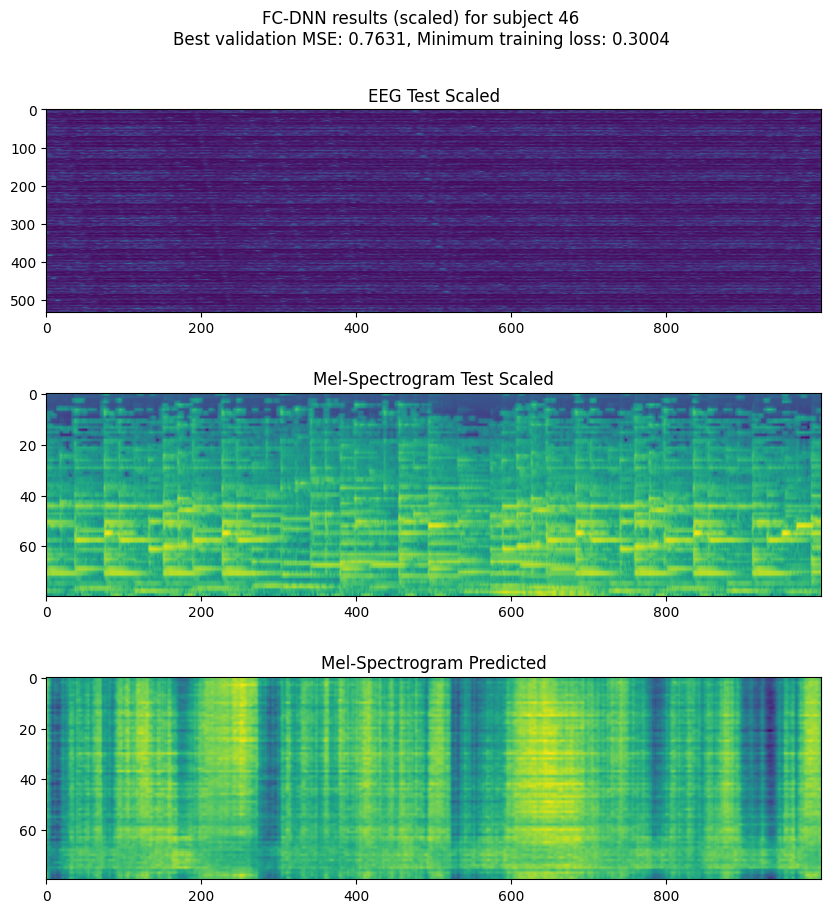

In [347]:
# melspec_predicted = model.predict(eeg_test_scaled[0:500])
melspec_predicted = model.predict(eeg_test_scaled[0:1000])
# melspec_predicted = melspec_predicted[0:500]
# test_melspec = test_melspec[]


#best stuff

best_val_mse = min(history.history['val_mean_squared_error'])
print(f'Best validation MSE: {best_val_mse:.4f}')

min_train_loss = min(history.history['loss'])
print(f'Minimum training loss: {min_train_loss:.4f}')


fig, axs = plt.subplots(3, 1, figsize=(10, 10))
axs[0].imshow(np.rot90(eeg_test_scaled[0:1000]), aspect='auto')
axs[0].set_title('EEG Test Scaled')
axs[1].imshow(np.rot90(melspec_test_scaled[0:1000]), aspect='auto')
axs[1].set_title('Mel-Spectrogram Test Scaled')
axs[2].imshow(np.rot90(melspec_predicted[0:1000]), aspect='auto')
axs[2].set_title('Mel-Spectrogram Predicted')
plt.suptitle(f'FC-DNN results (scaled) for subject {subject}\nBest validation MSE: {best_val_mse:.4f}, Minimum training loss: {min_train_loss:.4f}')
plt.subplots_adjust(hspace=0.4)


plt.savefig(model_name + '_EEG_scaled_plots.png')
plt.show()

